In [ ]:
!pip install rebound

     |████████████████████████████████| 255 kB 4.4 MB/s 
  Created wheel for rebound: filename=rebound-3.19.3-cp37-cp37m-linux_x86_64.whl size=604105 sha256=771b6cf603ce719ff2df122696d2a001e624bc9606d335e52879a85a3fa51263
  Stored in directory: /root/.cache/pip/wheels/b7/ad/4e/17f873dfcb15eeed866dba5f71b77ecb539b140abb6bd7eabf
Successfully built rebound


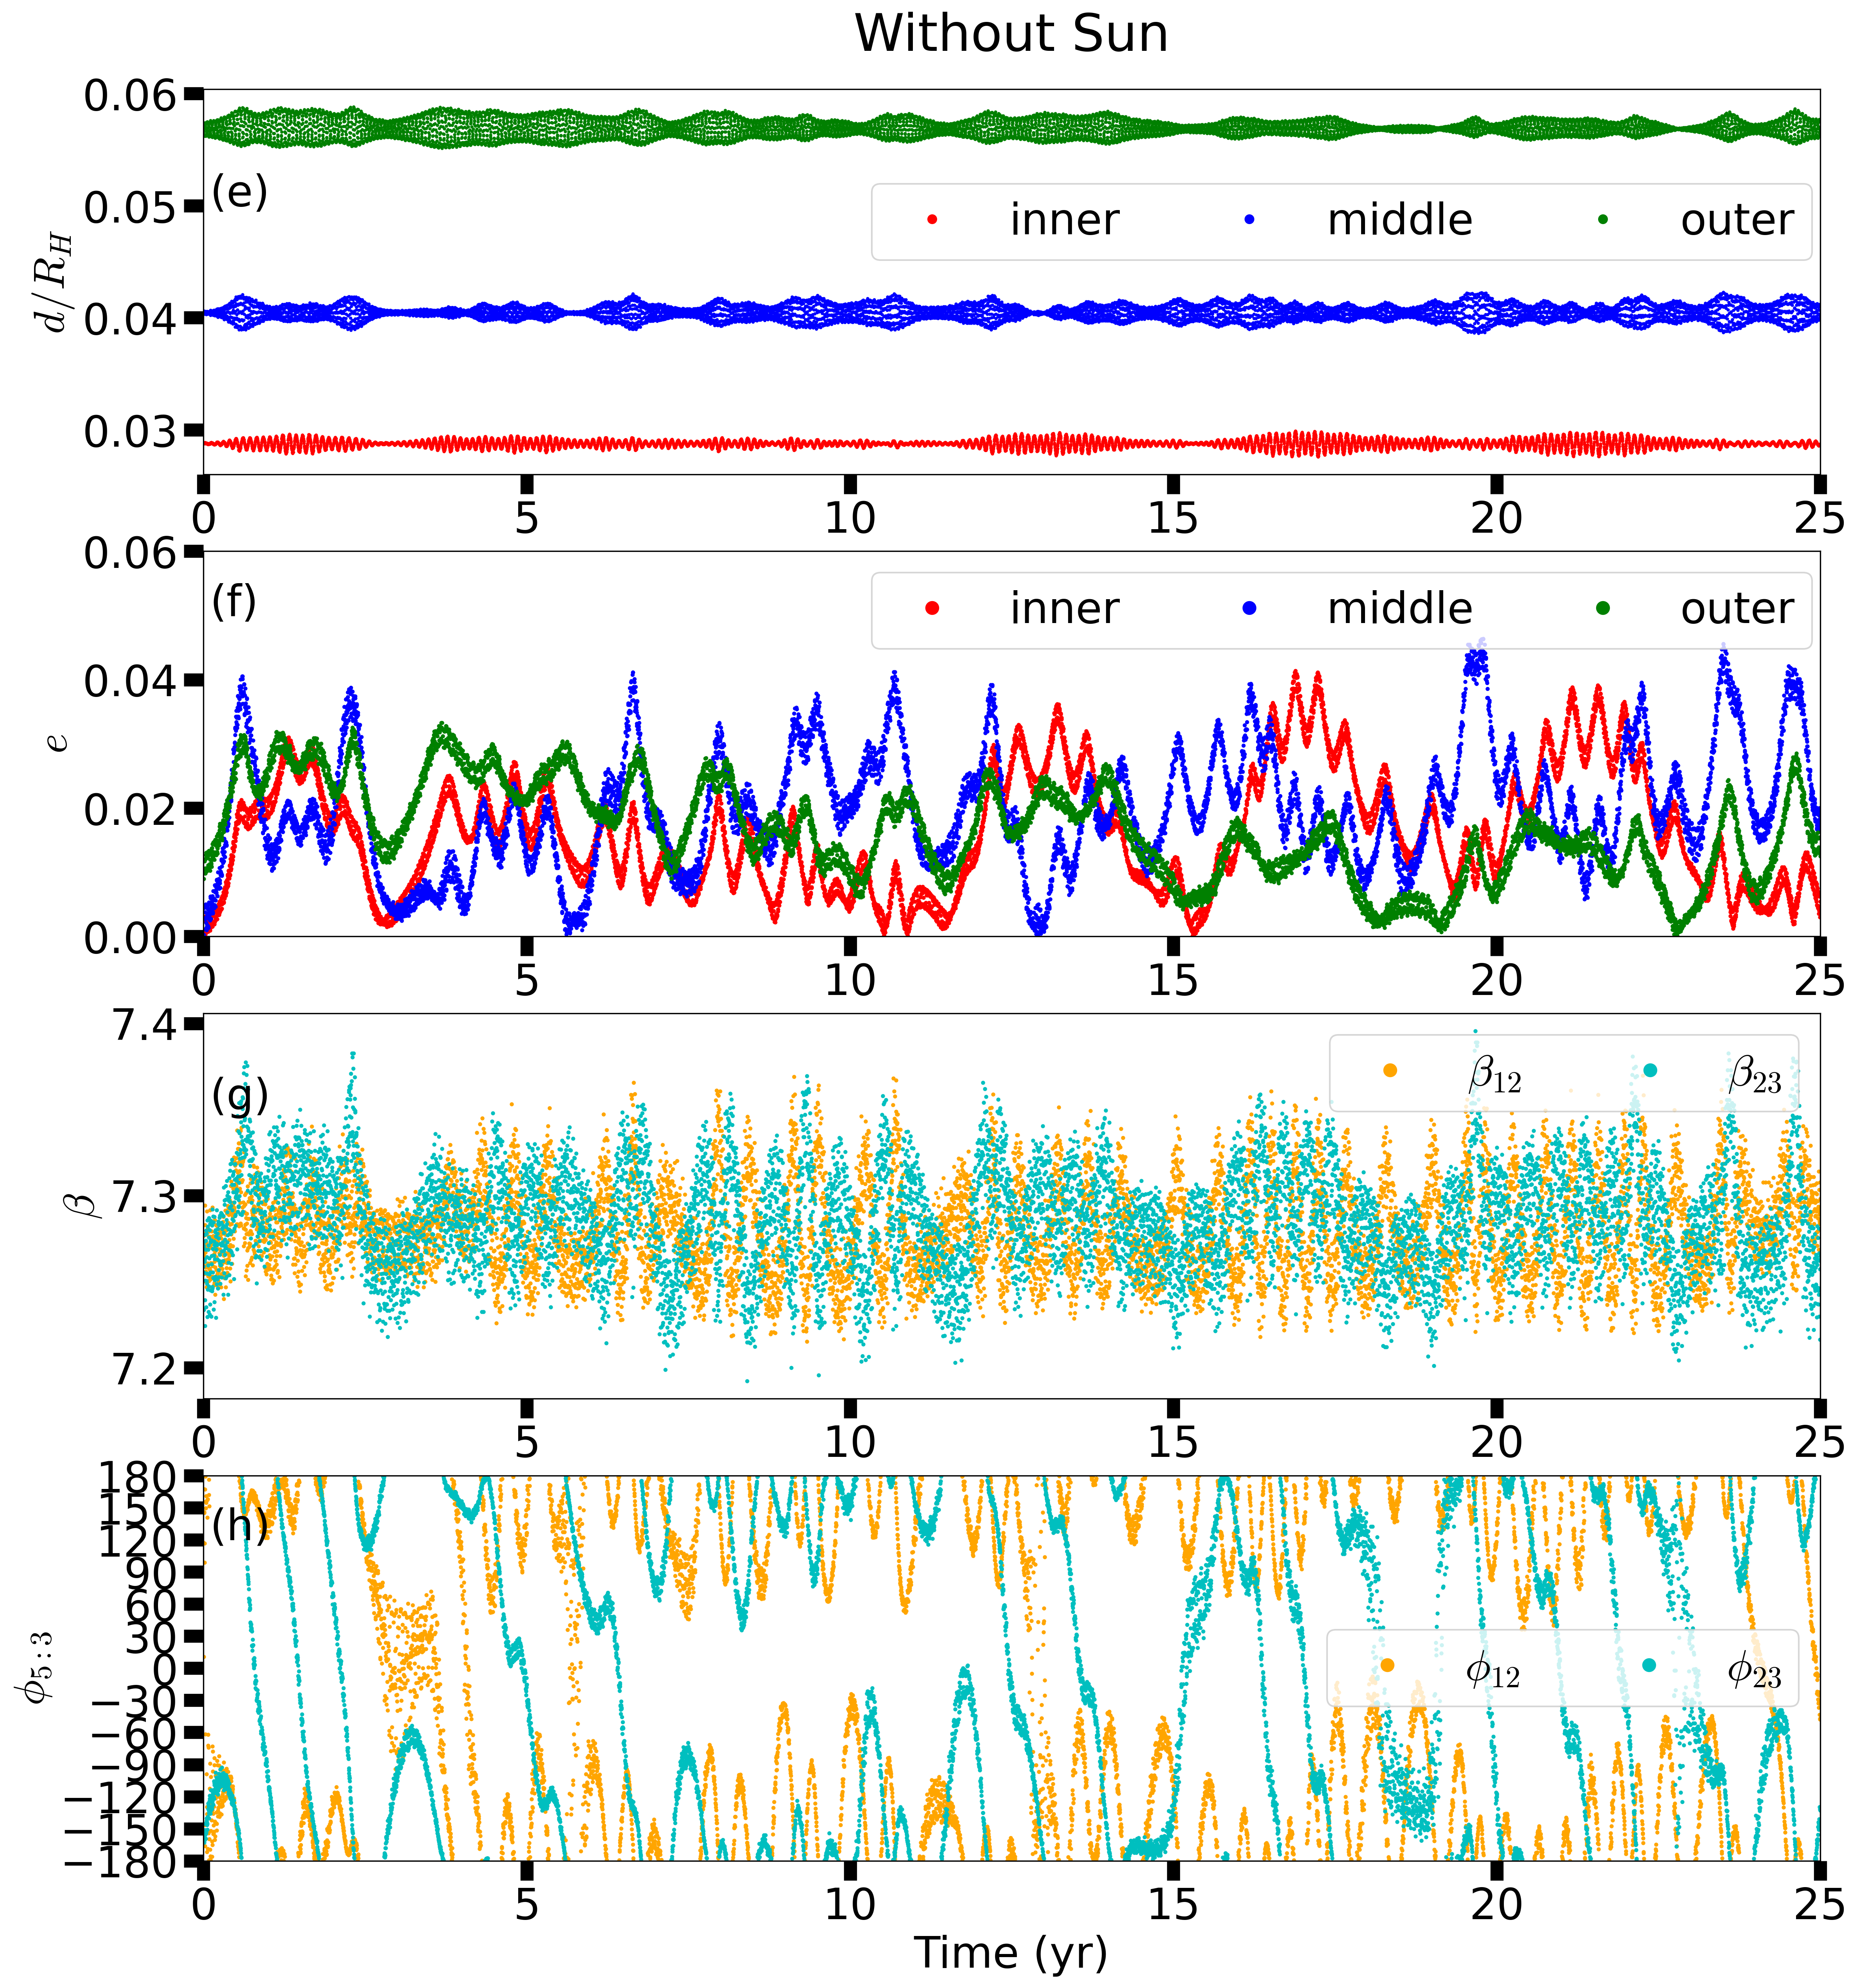

In [ ]:
import numpy as np
import rebound
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as mplcolors
from matplotlib import rcParams
from matplotlib import rc
import multiprocessing as mp
import subprocess as sb
import sys
import os

rcParams.update({'font.size': 22})
rcParams.update({'mathtext.fontset': 'cm'})


def get_semi(idx,beta,a_mo,M_i,M_p):
    M_tilde = M_p + idx*M_i
    X_m = 0.5*(2*M_i/(3*M_tilde))**(1./3.)
    return a_mo*((1.+beta*X_m)/(1-beta*X_m))**idx

def get_MA(idx):
    gold_ratio = (1.+np.sqrt(5.))/2.
    return np.radians(float(idx)*360.*gold_ratio % 360.)

def get_beta(a1,ao,j):
    M_tilde = M_E + j*M_moon
    R_Hm = 0.5*(a1+ao)*(2*M_moon/(3*M_tilde))**(1./3.)
    beta = (a1 - ao)/R_Hm
    return beta

def get_res_beta(PR,j):
    #p:q (or period ratio P_j/P_i)
    M_tilde = M_E+(j-1)*M_moon
    X_m = 0.5*(2*M_moon/(3.*M_tilde))**(1./3.)
    delta = (M_tilde/M_E)**(1./(3.*j))*(PR)**(2./(3.*j))
    beta = (delta-1.)/(1.+delta)/X_m
    return beta

def Cart2Orb(x,m_c,mp): #inverse function of Orb2Cart
    #routine to quickly convert Orbital elements to Cartesian coordinates
    temp_sim = rebound.Simulation()
    temp_sim.integrator = "none"
    temp_sim.units = ('yr', 'AU', 'Msun')
    temp_sim.add(m=m_c)
    temp_sim.add(m=mp,x=x[0],y=x[1],z=x[2],vx=x[3],vy=x[4],vz=x[5])
    temp_sim.move_to_hel()
    temp_ps = temp_sim.particles
    temp = [temp_ps[1].a,temp_ps[1].e,temp_ps[1].l,temp_ps[1].omega,temp_ps[1].P]
    return temp

def get_diff(ps,idx1,idx2):
    dx = ps[idx1].x - ps[idx2].x
    dy = ps[idx1].y - ps[idx2].y
    dz = ps[idx1].z - ps[idx2].z
    dvx = ps[idx1].vx - ps[idx2].vx
    dvy = ps[idx1].vy - ps[idx2].vy
    dvz = ps[idx1].vz - ps[idx2].vz
    return np.array([dx,dy,dz,dvx,dvy,dvz])


M_star = 1.0
M_E = 3.0035e-6
M_moon = 0.00015*M_E #Ceres mass
rho_moon = 2.08 #Ceres density (g/cc)
#M_moon = 1./81.*M_E # Luna mass
#rho_moon 3.3 #Luna density (g/cc)
R_Roche = 2.44*4.26352e-5*(5.515/rho_moon)**(1./3.)
#R_Roche = 2.88*4.26352e-5
#beta = 7.27, em = 0.01


em = 0.01
fs = 'large'
a_mo = 2.*R_Roche
T_mo = np.sqrt(a_mo**3/M_E)

R_H = 1.*(M_E/(3*M_star))**(1./3.)
n_moons = 3
with_Sun = False
def run_sim(beta_idx):
    beta = np.round(7.26 + 0.01*beta_idx,2)
    fname = "figs/MMR_test_wo-sun[%1.2f].pdf" % beta
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.ri_whfast.corrector = 11
    sim.units = ('yr','AU','Msun')
    sim.dt = T_mo/20./2.

    moon_semi = np.zeros(n_moons)
    if with_Sun == True:
        sim.add(m=1.,hash="Sun") #Sun-mass star
        sim.add(m=M_E,a=1,e=0.0167,hash="Earth")   #Earth-mass planet;
    else:
        sim.add(m=M_E,hash="Earth")   #Earth-mass planet; ,a=1,e=0.0167
    for i in range(0,n_moons):
        am = get_semi(i,beta,a_mo,M_moon,M_E)
        moon_semi[i] = am
        MA_m = get_MA(i+1)
        if i < (n_moons-1):
            sim.add(m=M_moon, a = am, e = 0.0, M=MA_m,primary=sim.particles["Earth"])
        else:
            sim.add(m=M_moon, a = am, e = em, M=MA_m,primary=sim.particles["Earth"])
    sim.move_to_com()
    '''sim.add(m=M_E)
    for i in range(0,n_moons):
        a_m = get_semi(i,beta,a_mo,M_moon,M_E)
        moon_semi[i] = a_m
        MA_m = get_MA(i)
        if i < (n_moons-1):
            sim.add(m=M_moon,a = a_m,M=np.radians(MA_m))
        else:
            sim.add(m=M_moon,a = a_m,e=em,M=np.radians(MA_m))
    sim.add(m=M_star,a=1.,e=0.0167)
    sim.move_to_com()'''
    ps = sim.particles

    '''for i in range(2,n_moons+2):
        #moon_orb = Cart2Orb(get_diff(ps,i,1),ps[1].m,ps[i].m)
        moon_orb = ps[i].calculate_orbit(primary=sim.particles[1])
        print(moon_orb.a,moon_orb.e,np.degrees(moon_orb.l),np.degrees(moon_orb.omega),moon_orb.P)'''

    #X_m = 0.5*(2*M_moon/(3*M_E))**(1./3.)
    #delta_m = 7.26*X_m

    #for i in range(0,n_moons-1):
    #    e_c = (moon_semi[i]+delta_m*moon_semi[i+1])/(1.-delta_m)/moon_semi[i+1] - 1
    #    print(e_c)
    if not os.path.exists(home+"bin"):
        os.makedirs(home+"bin")
    sim.automateSimulationArchive("bin/archive[%1.2f].bin" % beta, interval=1./365.25,deletefile=True)
    max_time = 25.
    sim.integrate(max_time)

    sa = rebound.SimulationArchive("bin/archive[%1.2f].bin" % beta)

    dpi = 300
    width = 10.
    aspect = 16./9.

    fig = plt.figure(figsize=(aspect*width,2*width),dpi=dpi)
    ax1 = fig.add_subplot(411)
    ax2 = fig.add_subplot(412)
    ax3 = fig.add_subplot(413)
    ax4 = fig.add_subplot(414)
    ax_list = [ax1,ax2,ax3,ax4]

    ax1.set_ylabel("$d/R_H$",fontsize=fs)
    ax2.set_ylabel("$e$",fontsize=fs)
    ax3.set_ylabel("$\\beta$",fontsize=fs)
    ax4.set_ylabel("$\phi_{5:3}$",fontsize=fs)

    ax4.set_ylim(-180.,180.)
    ax4.set_xlabel("Time (yr)",fontsize=fs)
    #ax2.set_ylim(0,0.01)

    for ax in ax_list:
        ax.set_xlim(0,max_time)
        ax.tick_params(which='major',axis='both', direction='out',length = 12.0, width = 8.0,labelsize=fs)
        #ax.minorticks_on()
        #ax.tick_params(which='minor',axis='both', direction='out',length = 8.0, width = 6.0)

    col = ['k','r']
    phi = np.zeros((len(sa),n_moons))
    beta_t = np.zeros((len(sa),n_moons))
    semi_t = np.zeros((len(sa),n_moons))
    ecc_t = np.zeros((len(sa),n_moons))
    time = np.zeros(len(sa))
    if with_Sun == True:
        start_idx = 2
    else:
        start_idx = 1
    for i in range(0,len(sa)):
        sim = sa[i]
        time[i] = sim.t
        ps = sim.particles

        for n in range(start_idx,n_moons+start_idx):
            '''s_n = get_diff(ps,n,1)
            s_n1 = get_diff(ps,n+1,1)

            orb_elem_n = Cart2Orb(s_n,M_E,M_moon)
            orb_elem_n1 = Cart2Orb(s_n1,M_E,M_moon)'''

            moon_n = ps[n].calculate_orbit(primary=sim.particles[0]) # 1 = with sun, 0: w/o sun
            semi_t[i,n-start_idx],ecc_t[i,n-start_idx],lambda_1,omg_1 = moon_n.d,moon_n.e,moon_n.l,moon_n.omega
            if n < n_moons + start_idx-1:
                moon_n1 = ps[n+1].calculate_orbit(primary=sim.particles[0]) # 1 = with sun, 0: w/o sun
                lambda_2,omg_2 = moon_n1.l,moon_n1.omega
                beta_t[i,n-start_idx] = get_res_beta(moon_n1.P/moon_n.P,1)
                phi[i,n-start_idx] = np.degrees(5*lambda_2-3*lambda_1 - 2*omg_2) % 360.
                if phi[i,n-start_idx] > 180.:
                    phi[i,n-start_idx] -= 360.
            #o = ps[n].calculate_orbit(primary=sim.particles[1])
            #print(o.P,o.e,o.l,o.omega)
            #beta_t[i,n-2] = get_res_beta(orb_elem_n1[-1]/orb_elem_n[-1],1)

    col = ['orange','c','r','b','g']
    beta_lbl = ['$\\beta_{12}$','$\\beta_{23}$']
    phi_lbl = ['$\\phi_{12}$','$\\phi_{23}$']
    moon_lbl = ['inner','middle','outer']
    for n in range(0,n_moons-1):
        ax3.plot(time,beta_t[:,n],'.',color=col[n],ms=3,label=beta_lbl[n])
        #ax1.plot(time,beta_t[:,1],'.',color='r',ms=5)
        ax4.plot(time,phi[:,n],'.',color=col[n],ms=3,label=phi_lbl[n])
    for n in range(0,n_moons):
        ax1.plot(time,semi_t[:,n]/R_H,'.',color=col[n+2],ms=2,label=moon_lbl[n])
        ax2.plot(time,ecc_t[:,n],'.',color=col[n+2],ms=3,label=moon_lbl[n])
        ax2.set_ylim([0.0,0.06])
        #ax2.plot(time,ecc_t[:,1],'.',color='r',ms=5)
    ax1.legend(loc='best',bbox_to_anchor=(0.4,0.5),fontsize=fs,ncol = 3, markerscale=5)
    ax2.legend(loc='upper left',bbox_to_anchor=(0.4,1.0),fontsize=fs, ncol = 3, markerscale=5)
    ax3.legend(loc='upper right',fontsize=fs, ncol = 2, markerscale=5)
    ax4.legend(loc='center right',fontsize=fs, ncol = 2, markerscale=5)

    ax1.text(0.5,1.1, "Without Sun", color='k',fontsize='x-large',horizontalalignment='center',transform=ax1.transAxes)
    ax1.text(0.1,0.05,'(e)',fontsize=fs)
    ax2.text(0.1,0.05,'(f)',fontsize=fs)
    ax3.text(0.1,7.35,'(g)',fontsize=fs)
    ax4.text(0.1,120,'(h)',fontsize=fs)

    yticks = np.arange(-180,210,30)
    ax4.set_yticks(yticks);
    #ax3.plot(time,phi[:,1],'.',color='r',ms=5)
    if not os.path.exists(home+"figs"):
        os.makedirs(home+"figs")
    fig.savefig(fname,bbox_inches='tight',dpi=dpi)
    #plt.close()

home = os.getcwd() + "/"
run_sim(0)


#pool = mp.Pool(processes=2)
#pool.map(run_sim,range(0,16))
#pool.close()

#sb.call('tar -czf MMR_test_woSun.tar.gz figs',shell=True)

# New Section

# New Section